In [1]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from encoding_information.information_estimation import *
from encoding_information.image_utils import *
from encoding_information.models.gaussian_process import *


from encoding_information.datasets.bsccm_utils import *
from bsccm import BSCCM
from jax import jit
import numpy as onp
import jax.numpy as np

bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

2024-10-12 21:54:35.559333: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-12 21:54:36.404451: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-10-12 21:54:36.404541: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-10-12 21:54:36.404550: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


Opening BSCCM
Opened BSCCM


### Now verify that mutual information estimates converge to the true value with increasing number of samples

  0%|                                                   | 0/3 [00:00<?, ?it/s]2024-10-12 21:54:52.168466: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1125] failed to alloc 536870912 bytes on host: CUDA_ERROR_INVALID_VALUE: invalid argument
2024-10-12 21:54:52.168498: W external/xla/xla/stream_executor/device_host_allocator.h:52] could not allocate pinned host memory of size: 536870912
2024-10-12 21:54:52.170051: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1125] failed to alloc 483183872 bytes on host: CUDA_ERROR_INVALID_VALUE: invalid argument
2024-10-12 21:54:52.170068: W external/xla/xla/stream_executor/device_host_allocator.h:52] could not allocate pinned host memory of size: 483183872
2024-10-12 21:54:52.170616: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1125] failed to alloc 434865664 bytes on host: CUDA_ERROR_INVALID_VALUE: invalid argument
2024-10-12 21:54:52.170628: W external/xla/xla/stream_executor/device_host_allocator.h:52] could not alloca

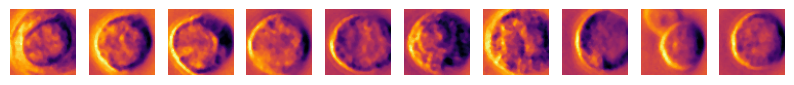

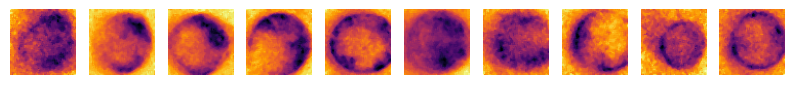

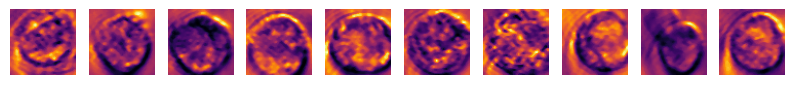

In [2]:
num_images = 10000
channels = ['DPC_Right', 'Brightfield', 'LED119']
# channels = ['LED119']
patch_size = 20
num_patches = 10000

images = {}
clean_patches_by_channel = {}
for channel in tqdm(channels):
    # load "clean" median filtered images
    images[channel] = load_bsccm_images(bsccm, channel=channel, num_images=num_images, edge_crop=32, median_filter=True)        
    clean_patches_by_channel[channel] = extract_patches(images[channel], num_patches, patch_size)

    # plot a montage of images
    num_to_plot = 10
    fig, ax = plt.subplots(1, num_to_plot, figsize=(num_to_plot, 1))
    for i in range(num_to_plot):
        ax[i].imshow(images[channel][i], cmap='inferno')
        ax[i].axis('off')

#### Compare conditional entropy of noisy to clean

In [3]:
from encoding_information.models import PixelCNN, PoissonNoiseModel

mean_photons = {channel: np.mean(images[channel]) for channel in images.keys()}
photons_per_pixel_list = [5, 10, 20, 40, 80, 160, 320]
# photons_per_pixel_list = [40, 80, 160, 320]

confidence = .95
test_fraction = 0.1
num_replicates = 5


def do_estimation(noisy_patches, clean_patches=None):
    pixelcnn = PixelCNN()
    pixelcnn.fit(noisy_patches, verbose=False)
    noise_model = PoissonNoiseModel()
    train_patches = noisy_patches[:int(len(noisy_patches) * (1 - test_fraction))]
    test_patches = noisy_patches[int(len(noisy_patches) * (1 - test_fraction)):]

    estimate, lower, upper = estimate_information(pixelcnn, noise_model, train_patches, test_patches, confidence_interval=confidence, clean_data=clean_patches)

    return estimate, lower, upper


results = {}
for channel in channels:
    results[channel] = []
    for photons_per_pixel in tqdm(photons_per_pixel_list):
        rescale_fractions = {channel: photons_per_pixel / mean_photons[channel] for channel in images.keys()}
        clean_patches = clean_patches_by_channel[channel] * rescale_fractions[channel]
        noisy_patches = add_noise(clean_patches, ensure_positive=True)

        noisy_mi_mean, noisy_mi_lower, noisy_mi_upper = do_estimation(noisy_patches)
        clean_mi_mean, clean_mi_lower, clean_mi_upper = do_estimation(noisy_patches, clean_patches)

        # take lowest estimate over replicates
        for replicate in range(1, num_replicates):
            noisy_mi_mean_, noisy_mi_lower_, noisy_mi_upper_ = do_estimation(noisy_patches)
            clean_mi_mean_, clean_mi_lower_, clean_mi_upper_ = do_estimation(noisy_patches, clean_patches)

            if noisy_mi_mean_ < noisy_mi_mean:
                noisy_mi_mean = noisy_mi_mean_
                noisy_mi_lower = noisy_mi_lower_
                noisy_mi_upper = noisy_mi_upper_

            if clean_mi_mean_ < clean_mi_mean:
                clean_mi_mean = clean_mi_mean_
                clean_mi_lower = clean_mi_lower_
                clean_mi_upper = clean_mi_upper_
        
        results[channel].append((noisy_mi_mean, noisy_mi_lower, noisy_mi_upper, clean_mi_mean, clean_mi_lower, clean_mi_upper))
        

  0%|                                                   | 0/7 [00:00<?, ?it/s]2024-10-12 21:57:12.568928: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.

training:  26%|███████▋                      | 51/200 [03:56<11:29,  4.63s/it]

Evaluating NLL: 0it [00:00, ?it/s]
Evaluating NLL: 1it [00:02,  2.87s/it]
Evaluating NLL: 17it [00:02,  7.89it/s]
Evaluating NLL: 32it [00:05,  6.23it/s]

Evaluating NLL: 0it [00:00, ?it/s]
Evaluating NLL: 1it [00:02,  2.35s/it]
Evaluating NLL: 44it [00:02, 24.98it/s]
Evaluating NLL: 82it [00:02, 51.74it/s]
Evaluating NLL: 122it [00:02, 85.27it/s]
Evaluating NLL: 164it [00:02, 125.95it/s]
Evaluating NLL: 207it [00:02, 170.44it/s]
Evaluating NLL: 252it [00:02, 218.51it/s]
Evaluating NLL: 296it [00:03, 261.87it/s]
Evaluating NLL: 341it [00:03, 302.77it/s]
Evaluating NLL: 389it [00:03, 343.71it/s]
Evaluating NLL: 436it [

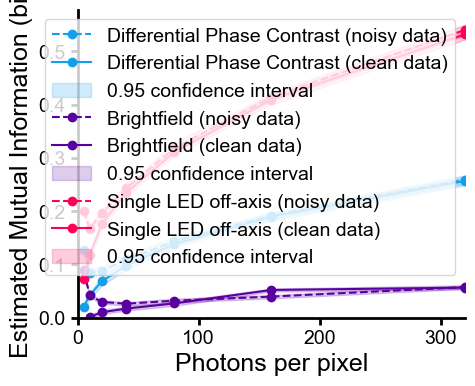

In [4]:
fig, ax = plt.subplots(figsize=(5, 4))

colors = get_color_cycle()
for color, (channel, channel_results) in zip(colors, results.items()):
    noisy_mi_means = []
    noisy_mi_intervals = []
    clean_mi_means = []
    clean_mi_intervals = []
    for noisy_mi_mean, noisy_mi_lower, noisy_mi_upper, clean_mi_mean, clean_mi_lower, clean_mi_upper in channel_results:
        noisy_mi_means.append(noisy_mi_mean)
        noisy_mi_intervals.append((noisy_mi_lower, noisy_mi_upper))
        clean_mi_means.append(clean_mi_mean)
        clean_mi_intervals.append((clean_mi_lower, clean_mi_upper))

    noisy_mi_means = np.array(noisy_mi_means)
    noisy_mi_intervals = np.array(noisy_mi_intervals)
    clean_mi_means = np.array(clean_mi_means)
    clean_mi_intervals = np.array(clean_mi_intervals)
    
    channel_name = get_display_channel_names(channel)

    ax.plot(photons_per_pixel_list, noisy_mi_means, 'o--', label=f"{channel_name} (noisy data)", color=color)
    ax.fill_between(photons_per_pixel_list, noisy_mi_intervals[:, 0], noisy_mi_intervals[:, 1], alpha=0.2, color=color)
    ax.plot(photons_per_pixel_list, clean_mi_means, 'o-', label=f"{channel_name} (clean data)", color=color)
    ax.fill_between(photons_per_pixel_list, clean_mi_intervals[:, 0], clean_mi_intervals[:, 1], alpha=0.2, color=color, label=f"{confidence} confidence interval")

clear_spines(ax)
ax.set(
    xlabel='Photons per pixel',
    ylabel='Estimated Mutual Information (bits)',
    xlim=[0, max(photons_per_pixel_list)],
    ylim=[0, None]
)
ax.legend()

fig.savefig('/home/hpinkard_waller/figures/mi_estimation/mi_vs_photon_count_noisy_vs_clean_cond_ent.pdf', transparent=True)
